In [1]:
import pandas as pd

# Load the provided data
file_path = 'final_df.csv'
df = pd.read_csv(file_path)

# Assumptions for capacity calculation
average_vehicle_length = 5  # in meters (average length of a passenger car)
safe_following_distance = 2  # in seconds (common safe following distance)
average_speed = 13.9  # in m/s (50 km/h, a common urban road speed)

# Calculate the safe distance in meters (using the 2-second rule)
safe_distance_meters = average_speed * safe_following_distance

# Total space occupied by one car (vehicle length + safe following distance)
total_space_per_car = average_vehicle_length + safe_distance_meters

# Adding an additional column for capacity estimation in the dataframe
df['Road_Capacity'] = df['L2_Distance']*100*1000 / total_space_per_car


df['Start_Node_ID'] = pd.to_numeric(df['Start_Node_ID'])
df['End_Node_ID'] = pd.to_numeric(df['End_Node_ID'])

df_reverse = df.copy()
df_reverse['Start_Node_ID'] = df['End_Node_ID']
df_reverse['End_Node_ID'] = df['Start_Node_ID']

df_combined = pd.concat([df, df_reverse], ignore_index=True)
df_combined

,Edge_ID,Start_Node_ID,End_Node_ID,L2_Distance,Start_Longitude,Start_Latitude,End_Longitude,End_Latitude,Road_Capacity
0,0,0,1,0.002025,-121.904167,41.974556,-121.902153,41.974766,6.173780
1,1,0,6,0.005952,-121.904167,41.974556,-121.910088,41.973942,18.146341
2,2,1,2,0.014350,-121.902153,41.974766,-121.896790,41.988075,43.750000
3,3,2,3,0.012279,-121.896790,41.988075,-121.889603,41.998032,37.435976
4,4,3,4,0.011099,-121.889603,41.998032,-121.886681,42.008739,33.838415
...,...,...,...,...,...,...,...,...,...
43381,21688,21043,21042,0.003753,-117.040733,32.553684,-117.042160,32.550213,11.442073
43382,21689,21044,21043,0.003599,-117.042160,32.550213,-117.043533,32.546886,10.972561
43383,21690,21045,21044,0.013969,-117.043533,32.546886,-117.055840,32.553497,42.588415
43384,21691,21047,21044,0.009922,-117.043533,32.546886,-117.035332,32.541302,30.250000


In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [13]:
# Oakland

min_latitude, max_latitude = 37.7, 37.9
min_longitude, max_longitude = -122.4, -122.1

# Make a subset for the bay area
df_oakland = df_combined[(df_combined['Start_Latitude'].between(min_latitude, max_latitude)) & 
            (df_combined['End_Latitude'].between(min_latitude, max_latitude)) & 
            (df_combined['Start_Longitude'].between(min_longitude, max_longitude)) & 
            (df_combined['End_Longitude'].between(min_longitude, max_longitude))
        ]

# Oakland

df_sans_oakland = pd.merge(df_combined, df_oakland, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
df_sans_oakland_small = df_sans_oakland[(df_sans_oakland['Start_Latitude'].between(min_latitude-.5, max_latitude+.5)) & 
            (df_sans_oakland['End_Latitude'].between(min_latitude-.5, max_latitude+.5)) & 
            (df_sans_oakland['Start_Longitude'].between(min_longitude-.5, max_longitude+.5)) & 
            (df_sans_oakland['End_Longitude'].between(min_longitude-.5, max_longitude+.5))
        ]

df_oakland_window = df_combined[(df_combined['Start_Latitude'].between(min_latitude-.5, max_latitude+.5)) & 
            (df_combined['End_Latitude'].between(min_latitude-.5, max_latitude+.5)) & 
            (df_combined['Start_Longitude'].between(min_longitude-.5, max_longitude+.5)) & 
            (df_combined['End_Longitude'].between(min_longitude-.5, max_longitude+.5))
        ]

In [14]:
shelter_nodes = df_sans_oakland_small
source_nodes = df_oakland
# Lists of shelter and source nodes -> to be used in the plot
shelter_nodes_list = shelter_nodes['End_Node_ID'].tolist()
source_nodes_list = source_nodes['End_Node_ID'].tolist()

# Base Graph
G = nx.DiGraph()

# Draw nodes and edges
for _, row in df_oakland_window.iterrows():
    # Add nodes
    G.add_node(row['Start_Node_ID'], type='StartNode')
    G.add_node(row['End_Node_ID'], type='EndNode')
    # Add edges
    G.add_edge(row['Start_Node_ID'], row['End_Node_ID'], capacity=row['Road_Capacity'], weight=row['L2_Distance'])

# Set node positions to map the locations with the node Ids
node_positions = {}
for _, row in df_oakland_window.iterrows():
    node_positions[row['Start_Node_ID']] = (row['Start_Longitude'], row['Start_Latitude'])
    node_positions[row['End_Node_ID']] = (row['End_Longitude'], row['End_Latitude'])

In [15]:
from networkx.algorithms.flow import edmonds_karp

# For each source node
for source in source_nodes_list:
    # For each shelter node
    for sink in shelter_nodes_list:
        # Find the optimal (shortest) path from the source to the shelter
        try:
            if source == sink:
                pass
            else:
                flow_value, flow_dict = nx.maximum_flow(G, source, sink, capacity='capacity', flow_func=edmonds_karp)
        except nx.NetworkXNoPath:
            pass


In [16]:
flow_value

8.823170731707318

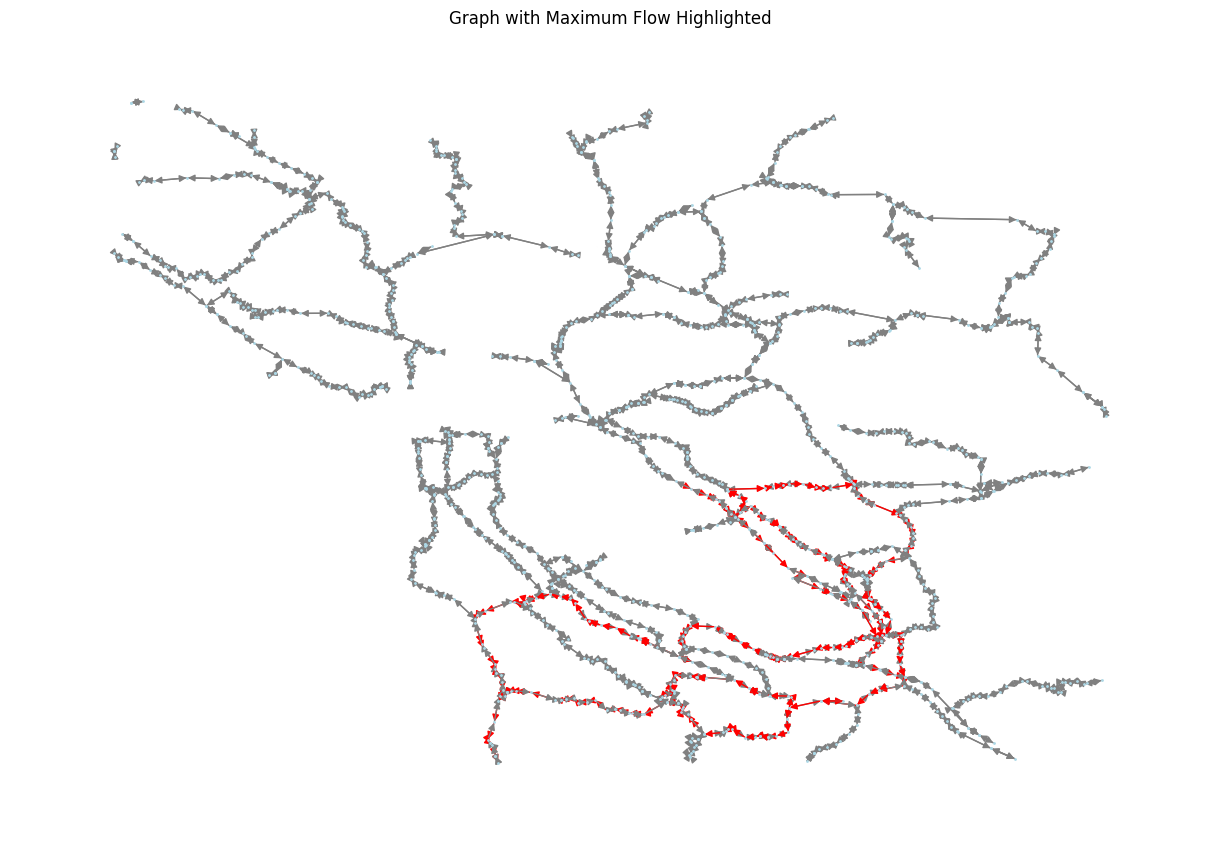

In [18]:
# Creating a color map based on the flow
edge_colors = []
for u, v in G.edges():
    flow = flow_dict[u][v]  # Retrieve actual flow data
    if flow > 0:
        edge_colors.append('red')  # Flow is present
    else:
        edge_colors.append('gray')  # No flow

# Plotting the graph with fixed positions based on longitude and latitude
plt.figure(figsize=(12, 8))
nx.draw(G, pos=node_positions, with_labels=False, edge_color=edge_colors, width=1, 
        node_color='lightblue', node_size=1, font_size=10)
plt.title("Graph with Maximum Flow Highlighted")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()
